In [ ]:
pip install tensorflow keras numpy pandas opencv-python matplotlib seaborn


In [ ]:
%pylab inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image

from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, Flatten, MaxPooling2D, Reshape, InputLayer, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img
import cv2


Populating the interactive namespace from numpy and matplotlib


In [ ]:
!pip install scikit-plot
%pip install scikit-plot


In [ ]:
!pip install scipy==1.10.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 48.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.1 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.


In [ ]:
!pip install scikit-plot


In [ ]:
%pip install scikit-plot


In [ ]:
df = pd.read_csv('/content/fer2013[1].csv')
print(df.shape)
df.head()

(1497, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
from google.colab import sheets
0sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1KC10lXikF3i2C8WTVPVzlAzSiei2qtp8-qitLNwf58s#gid=0


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
df.emotion.value_counts()

,count
emotion,
3,351
6,250
0,238
2,237
4,231
5,173
1,17


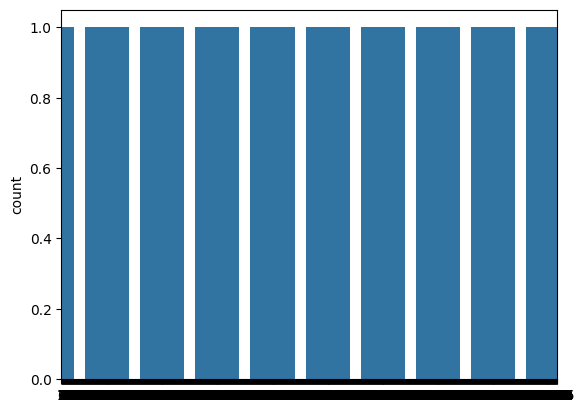

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt # Make sure pyplot is imported as plt

sns.countplot(df.emotion)
plt.show() # Use plt.show() instead of pyplot.show()

In [ ]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

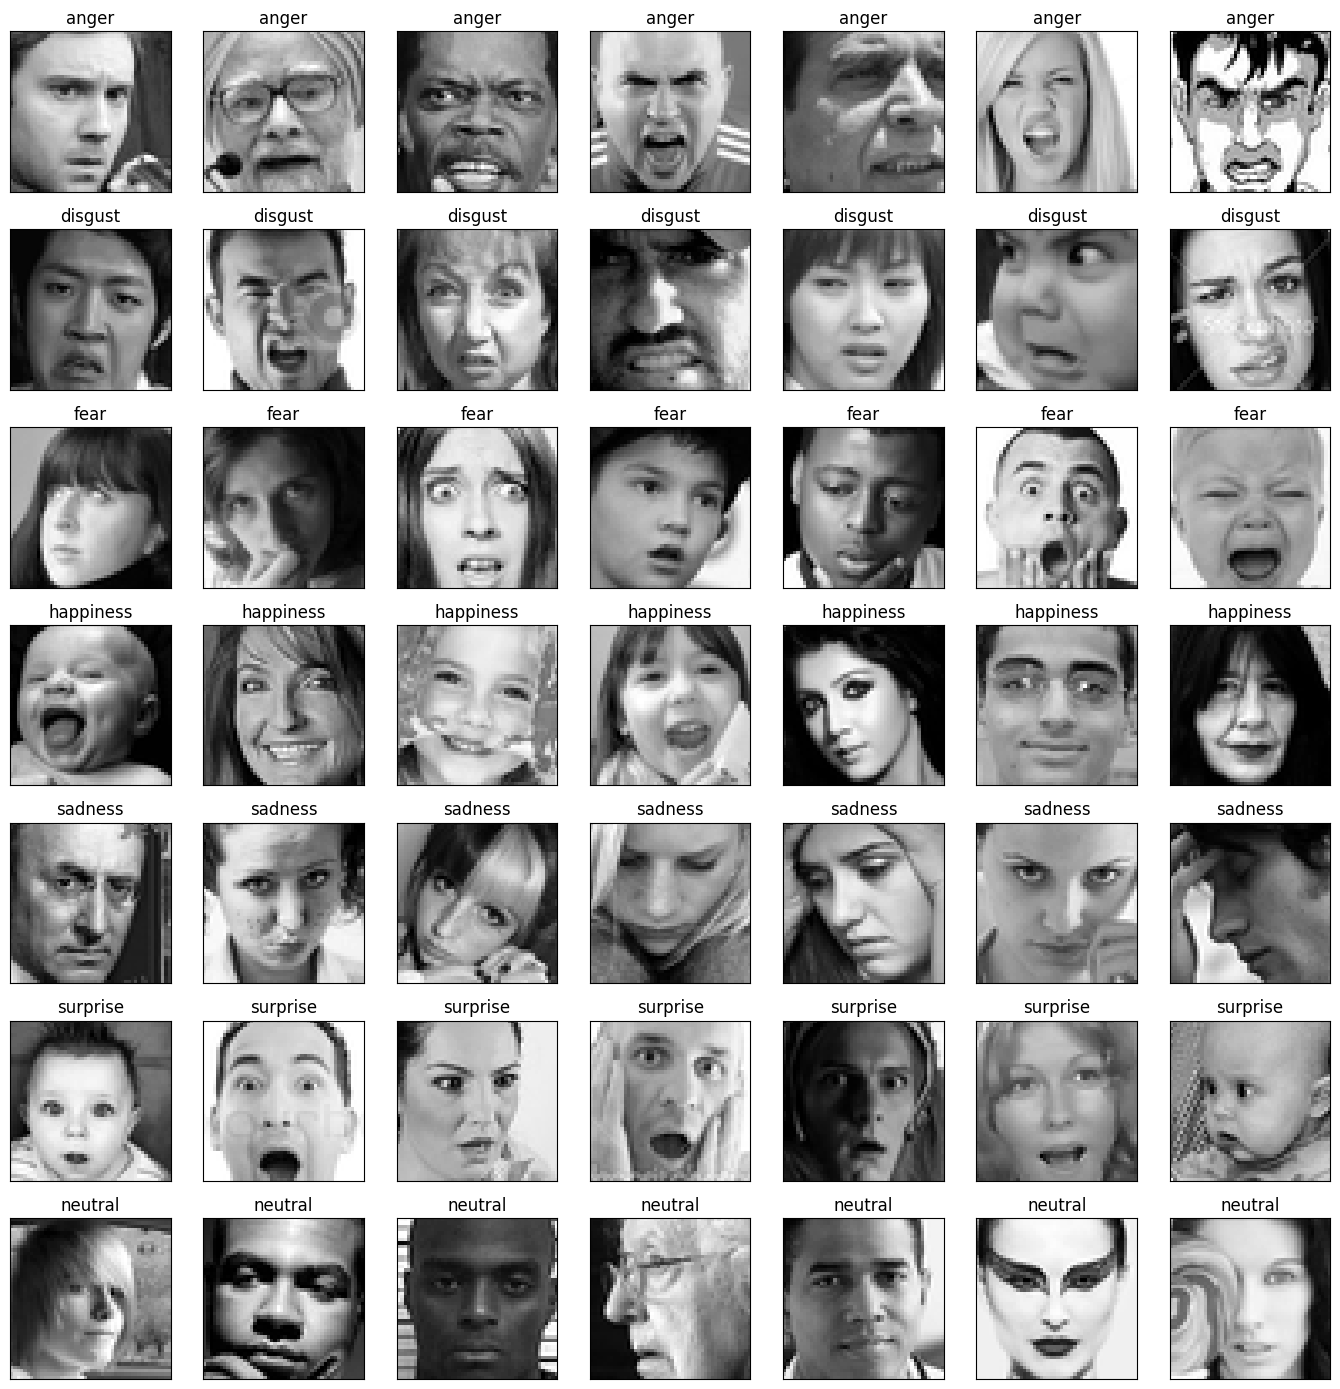

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(1, (14, 14))  # Use plt instead of pyplot

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)  # Use plt instead of pyplot
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()  # Use plt instead of pyplot


In [ ]:
INTERESTED_LABELS = [3, 4, 6]

In [ ]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(832, 3)

Now I will make the data compatible for neural networks.



In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(832, 48, 48, 1)

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Encode labels using LabelEncoder
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)

# Apply one-hot encoding using to_categorical
img_labels = to_categorical(img_labels)

# Check the shape
img_labels.shape


(832, 3)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Encode labels using LabelEncoder
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)

# Apply one-hot encoding
img_labels = to_categorical(img_labels)

# Split data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                      shuffle=True, stratify=img_labels,
                                                      test_size=0.1, random_state=42)

# Check the shapes
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((748, 48, 48, 1), (84, 48, 48, 1), (748, 3), (84, 3))

In [ ]:
del df
del img_array
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

# Reduce learning rate when a plateau is detected
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

# List of callbacks to use during model training
callbacks = [
    early_stopping,
    lr_scheduler,
]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# As the data in hand is less compared to the task, ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)


In [ ]:
# Calculate steps_per_epoch as an integer using floor division
steps_per_epoch = len(X_train) // batch_size  # Use // for integer result

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=steps_per_epoch,  # Pass integer value
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.4478 - loss: 1.1730 - val_accuracy: 0.5238 - val_loss: 1.0508 - learning_rate: 6.2500e-05
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.3438 - loss: 1.5645 - val_accuracy: 0.5238 - val_loss: 1.0514 - learning_rate: 6.2500e-05
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.4873 - loss: 1.1585 - val_accuracy: 0.5000 - val_loss: 1.0704 - learning_rate: 6.2500e-05
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5312 - loss: 1.1926 - val_accuracy: 0.5000 - val_loss: 1.0707 - learning_rate: 6.2500e-05
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.4323 - loss: 1.2171 - val_accuracy: 0.4762 - val_loss: 1.0979 - learning_rate: 6.2500e-05
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.5000 - loss: 1.0084 - val_accuracy: 0.4762 - val_loss: 1.0987 - learning_rate: 6.2500e-05
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.4

In [ ]:
img_width = 48
img_height = 48


In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model

def build_net(optimizer):
    inputs = Input(shape=(48, 48, 1))  # Adjust this to your input size
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)

    # Calculate the flattened size dynamically
    dense_units = x.shape[1]  # Automatically calculates the correct number of units
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    outputs = Dense(3, activation='softmax')(x)  # Adjust output units if needed
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load a pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze layers of the base model
base_model.trainable = False

# Add custom classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


<ipython-input-50-89f6d6453046>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [ ]:
!pip install scipy==0.3.7


ERROR: Ignored the following yanked versions: 1.11.0, 1.14.0rc1
ERROR: Ignored the following versions that require a different python version: 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11
ERROR: Could not find a version that satisfies the requirement scipy==0.3.7 (from versions: 0.8.0, 0.9.0, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.13.0, 0.13.1, 0.13.2, 0.13.3, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.16.0, 0.16.1, 0.17.0, 0.17.1, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 1.0.0, 1.0.1, 1.1.0, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.4.0, 1.4.1, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 1.5.4, 1.6.0, 1.6.1, 1.9.0rc1, 1.

In [ ]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Sat Feb  8 19:18:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_net(optimizer):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')  # 7 classes for facial emotions
    ])

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Now, define optimizers and call the function
batch_size = 32
epochs = 100

optims = [
    optimizers.Nadam(learning_rate=0.001),
    optimizers.Adam(learning_rate=0.001),
]

model = build_net(optims[1])  # Using Adam optimizer


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras import Sequential, Input, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_net(optimizer):
    model = Sequential([
        Input(shape=(48, 48, 1)),  # ✅ Use Input() instead of input_shape in Conv2D
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')  # 7 classes for facial emotions
    ])

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Now, define optimizers and call the function
batch_size = 32
epochs = 100

optims = [
    optimizers.Nadam(learning_rate=0.001),
    optimizers.Adam(learning_rate=0.001),
]

model = build_net(optims[1])  # Using Adam optimizer


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Load the dataset (ensure the correct path to your CSV file)
df = pd.read_csv('/content/fer2013.csv')  # Reload the dataframe

# Extract image data and labels, handling potential errors and keeping track of valid indices
img_array = []
valid_indices = []  # Store indices of valid rows
for index, row in df.iterrows():
    try:
        pixels = np.array(row['pixels'].split(' '), dtype='float32').reshape(48, 48, 1)
        img_array.append(pixels)
        valid_indices.append(index)  # Add index if pixel data is valid
    except ValueError:
        print(f"Skipping row {index} due to invalid pixel data.")

img_array = np.stack(img_array, axis=0)

# Filter the DataFrame to keep only rows with valid pixel data
df = df.iloc[valid_indices]  # Filter the dataframe based on valid_indices

# Encode labels using the filtered DataFrame
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion) # This line was incomplete and causing the error.
#It is likely that the user intended to use 'img_labels' and apply fit_transform on 'df.emotion'.

# Continue with the rest of your code to apply one-hot encoding and split the data
img_labels = to_categorical(img_labels)

# ... rest of the code ...

Skipping row 747 due to invalid pixel data.


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers
# Import TensorFlow
import tensorflow as tf  # Make sure TensorFlow is imported

# ... (Rest of your code) ...


from tensorflow.keras import optimizers
# Assuming X_train, y_train, X_valid, y_valid, and other necessary variables are defined from the previous code.

# Define the build_net function (replace with your actual function if different)
def build_net(optimizer):
    model = tf.keras.models.Sequential([ # Now 'tf' is recognized here
        tf.keras.layers.Input(shape=(48, 48, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

batch_size = 32
epochs = 100

optims = [
    optimizers.Nadam(learning_rate=0.001),
    optimizers.Adam(learning_rate=0.001),
]

model = build_net(optims[1])  # Use Adam optimizer

# ... (Rest of your code) ...

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the dataset
df = pd.read_csv('/content/fer2013.csv')  # Ensure the correct file path

# Convert pixel values into NumPy arrays, handling potential errors
img_array = []
valid_indices = []  # To keep track of valid rows

for index, row in df.iterrows():
    try:
        pixels = np.array(row['pixels'].split(), dtype='float32').reshape(48, 48, 1)
        img_array.append(pixels)
        valid_indices.append(index)
    except ValueError:
        print(f"Skipping row {index} due to invalid pixel data.")

img_array = np.stack(img_array, axis=0)

# Filter the DataFrame based on valid_indices
df = df.iloc[valid_indices]

# Encode labels
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)  # Convert labels to numbers
img_labels = to_categorical(img_labels)    # Convert to one-hot encoding

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    img_array, img_labels,
    shuffle=True,
    stratify=img_labels,
    test_size=0.1,
    random_state=42  # Ensures reproducibility
)

# Normalize the data (Scale pixel values between 0 and 1)
X_train = X_train / 255.0
X_valid = X_valid / 255.0

# Define ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

# Use train_datagen.flow() instead of passing raw data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Define callbacks (ensure you define them if needed)
callbacks = []  # Example: callbacks=[EarlyStopping(monitor='val_loss', patience=5)]

# Train the model
history = model.fit(
    train_generator,
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) // 32,  # Adjust batch size if needed
    epochs=100,  # Adjust based on needs
    callbacks=callbacks,
)

Skipping row 747 due to invalid pixel data.
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.1603 - loss: 3.8798 - val_accuracy: 0.2267 - val_loss: 1.9220
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.2049 - loss: 2.3034 - val_accuracy: 0.2267 - val_loss: 1.9095
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2433 - loss: 1.9509 - val_accuracy: 0.2667 - val_loss: 1.8472
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2598 - loss: 1.9035 - val_accuracy: 0.2267 - val_loss: 1.8754
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2335 - loss: 1.9050 - val_accuracy: 0.2533 - val_loss: 1.9606
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2070 - loss: 1.9182 - val_accuracy: 0.1333 - val_loss: 2.1082
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2181 - loss: 1.9034 - val_accuracy: 0.1733 - val_loss: 2.1889
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2136 - loss: 1.8794 - val_accuracy: 0.2000 - val_l

In [ ]:
# Save model architecture as JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights - Correct the filename to include .weights.h5
model.save_weights("model_weights.weights.h5") # Added '.weights' to the filename

# Save the entire model (architecture + weights + optimizer state)
model.save("model.h5")

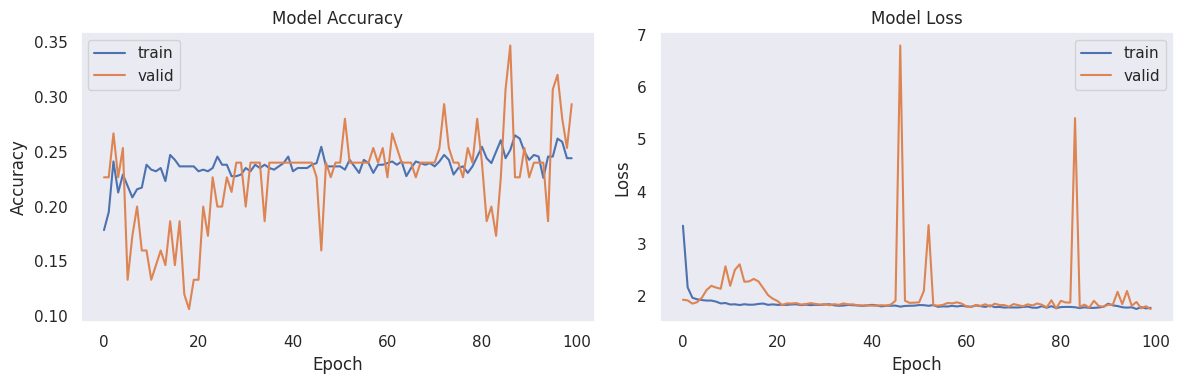

In [ ]:
import matplotlib.pyplot as pyplot
import seaborn as sns

sns.set()  # Apply Seaborn style

fig = pyplot.figure(figsize=(12, 4))

# Plot Accuracy
ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=range(len(history.epoch)), y=history.history['accuracy'], label='train')
sns.lineplot(x=range(len(history.epoch)), y=history.history['val_accuracy'], label='valid')
pyplot.title('Model Accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.legend()
pyplot.grid()

# Plot Loss
ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=range(len(history.epoch)), y=history.history['loss'], label='train')
sns.lineplot(x=range(len(history.epoch)), y=history.history['val_loss'], label='valid')
pyplot.title('Model Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.grid()

# Save and Show
pyplot.tight_layout()
pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()


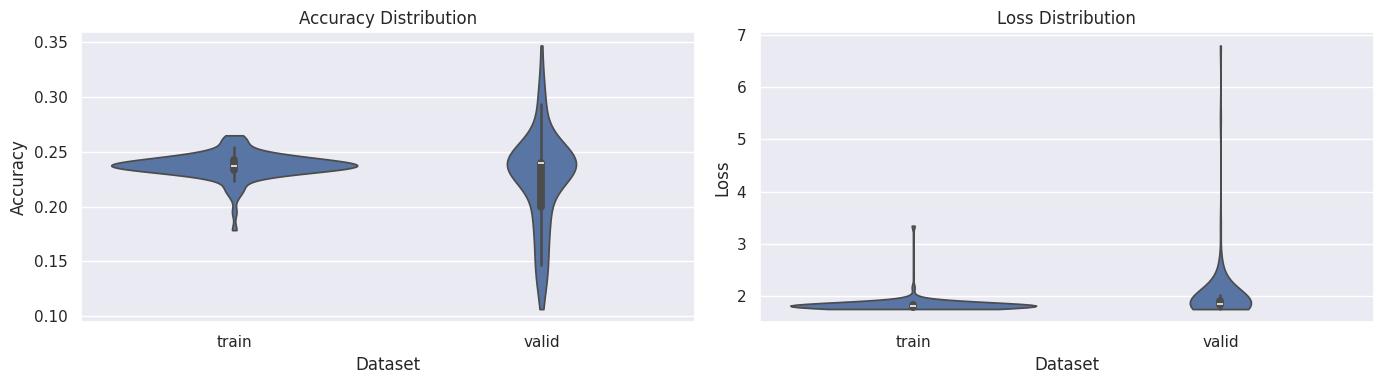

In [ ]:
import matplotlib.pyplot as pyplot
import seaborn as sns
import pandas as pd

# Ensure history.history contains the required keys
if 'accuracy' in history.history and 'val_accuracy' in history.history:
    df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
    df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

    # Melt the data for Seaborn
    df_accu_melted = df_accu.melt(var_name="Dataset", value_name="Accuracy")
    df_loss_melted = df_loss.melt(var_name="Dataset", value_name="Loss")

    # Create the figure
    fig = pyplot.figure(figsize=(14, 4))

    # Violin plot for accuracy
    ax = pyplot.subplot(1, 2, 1)
    sns.violinplot(x="Dataset", y="Accuracy", data=df_accu_melted, cut=0)  # Removed 'showfliers'
    pyplot.title('Accuracy Distribution')

    # Violin plot for loss
    ax = pyplot.subplot(1, 2, 2)
    sns.violinplot(x="Dataset", y="Loss", data=df_loss_melted, cut=0)  # Removed 'showfliers'
    pyplot.title('Loss Distribution')

    # Adjust layout and save
    pyplot.tight_layout()
    pyplot.savefig('performance_dist.png')
    pyplot.show()

else:
    print("Error: Training history does not contain 'accuracy' and 'val_accuracy'. Check model training.")


In [ ]:
!pip install scipy==1.9.3


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


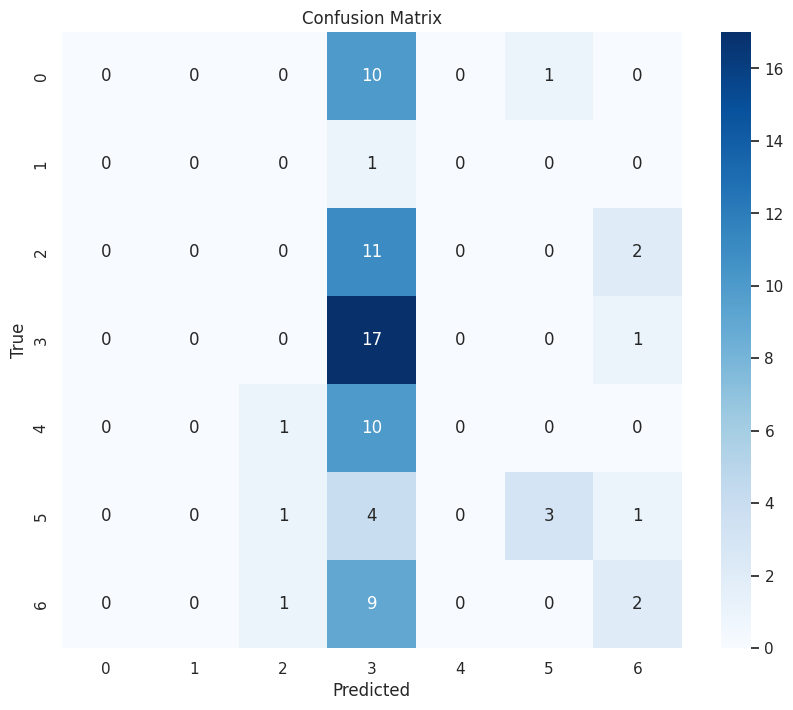

Total wrong validation predictions: 53


In [ ]:
# prompt: total wrong validation predictions?

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_valid contains the true labels and y_pred contains the predicted labels
y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid, axis=1)

conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate the total number of wrong predictions
wrong_predictions = np.sum(y_true != y_pred_classes)
print(f"Total wrong validation predictions: {wrong_predictions}")


In [ ]:
# prompt: precision    recall  f1-score   support

import numpy as np
from sklearn.metrics import classification_report

# Assuming y_valid contains true labels and y_pred contains predicted probabilities
y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_valid, axis=1)       # Convert one-hot encoded labels to class labels

# Generate the classification report
report = classification_report(y_true, y_pred_classes)
report


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00        11\n           1       0.00      0.00      0.00         1\n           2       0.00      0.00      0.00        13\n           3       0.27      0.94      0.42        18\n           4       0.00      0.00      0.00        11\n           5       0.75      0.33      0.46         9\n           6       0.33      0.17      0.22        12\n\n    accuracy                           0.29        75\n   macro avg       0.19      0.21      0.16        75\nweighted avg       0.21      0.29      0.19        75\n'

In [ ]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


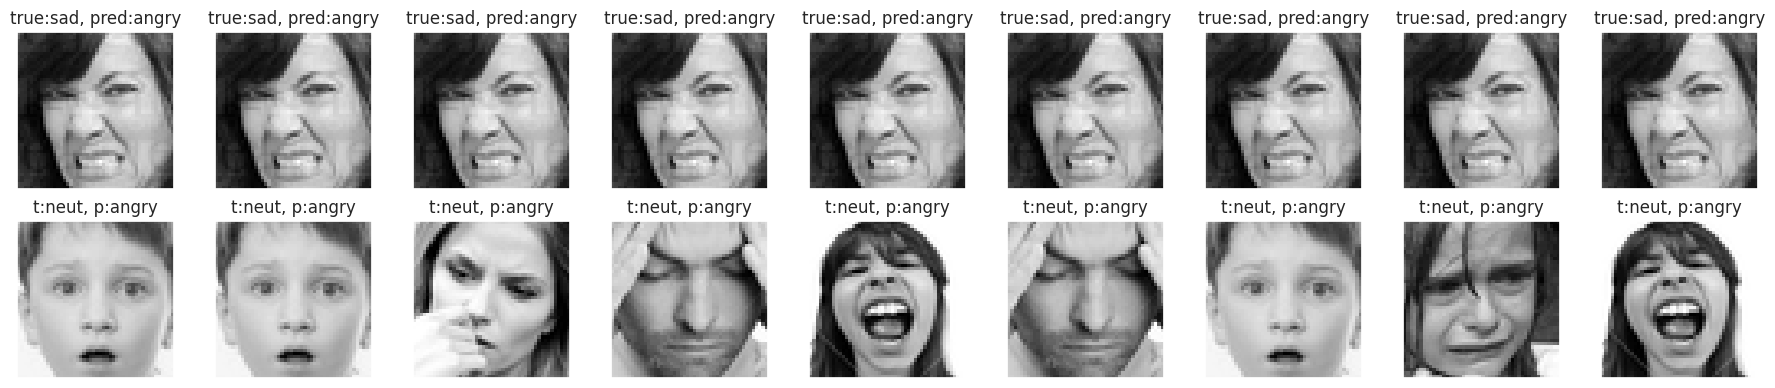

In [ ]:
import numpy as np
import matplotlib.pyplot as pyplot

# Update mapper with all emotion classes
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
    3: "angry",
    4: "surprised",
    5: "disgusted",
    6: "fearful",
}

# Randomly select indices for 'sad' and 'neutral' emotion classes
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1] == 1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2] == 1)[0], size=9)

# Set up the figure for displaying images
fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    # Plot for 'sad' images
    ax = pyplot.subplot(2, 9, i + 1)
    sample_img = X_valid[sadidx, :, :, 0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    pred_sad = np.argmax(model.predict(sample_img.reshape(1, 48, 48, 1)), axis=1)[0]
    ax.set_title(f"true:sad, pred:{mapper[pred_sad]}")

    # Plot for 'neutral' images
    ax = pyplot.subplot(2, 9, i + 10)
    sample_img = X_valid[neuidx, :, :, 0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    pred_neut = np.argmax(model.predict(sample_img.reshape(1, 48, 48, 1)), axis=1)[0]
    ax.set_title(f"t:neut, p:{mapper[pred_neut]}")

# Adjust layout and display
pyplot.tight_layout()
pyplot.show()


See in the first row 7th image looks more like neutral rather than sad and our model even predicted it neutral. Whereas the last image in second row is very much sad
